In [270]:
import numpy as np
import os
import pyloudnorm as pyln
from openai import OpenAI
import librosa
import scipy.fft as fft

import sys, random  
sys.path.insert(0, '../')
import utils
from utils.audio_generation import sample, get_model
from utils.audio_processing import compress_spectrogram_simple, compress_spectrogram_with_centroid, \
butter_bandpass_filter, change_loudness, butter_bandpass_filter_withgain,butter_bandpass


%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [4]:
# model_name = 'audioldm_16k_crossattn_t5' # Smaller model; Less GPU memory ~[6-9]GB; 
model_name = 'audioldm2-full' # Larger model; More GPU memory ~[12-15] GB; 

#Audio params
loudness_dbfs = -14.0
sample_rate = 16000
stft_channels = 1024
hop_length = 128

# Diffusion params
guidance_scale = 3
n_candidates = 1
batch_size = 1
ddim_steps = 100

In [5]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [6]:
latent_diffusion = get_model(model_name)

Loading model
Loading AudioLDM-2: audioldm2-full
Loading model on cuda:0
{'log_directory': './log/audiomae_pred', 'precision': 'high', 'data': {'train': ['audiocaps', 'audioset', 'wavcaps', 'audiostock_music_250k', 'free_to_use_sounds', 'epidemic_sound_effects', 'vggsound', 'million_song_dataset'], 'val': 'audiocaps', 'test': 'audiocaps', 'class_label_indices': 'audioset', 'dataloader_add_ons': ['extract_kaldi_fbank_feature', 'extract_vits_phoneme_and_flant5_text', 'waveform_rs_48k']}, 'variables': {'sampling_rate': 16000, 'mel_bins': 64, 'latent_embed_dim': 8, 'latent_t_size': 256, 'latent_f_size': 16, 'in_channels': 8, 'optimize_ddpm_parameter': True, 'warmup_steps': 5000}, 'step': {'validation_every_n_epochs': 1, 'save_checkpoint_every_n_steps': 5000, 'limit_val_batches': 10, 'max_steps': 1500000, 'save_top_k': 2}, 'preprocessing': {'audio': {'sampling_rate': 16000, 'max_wav_value': 32768, 'duration': 10.24}, 'stft': {'filter_length': 1024, 'hop_length': 160, 'win_length': 1024}, 'm

# Foley Interpreter

In [7]:
with open('../config/.env', 'r') as fh:
    vars_dict = dict(
        tuple(line.replace('\n', '').split('='))
        for line in fh.readlines() if not line.startswith('#')
    )

os.environ.update(vars_dict)

In [8]:
client = OpenAI()
def foley_interpreter(txt):
    content = "Describe a language phrase consisting of a noun verb adjective adverb like "+\
            "'a brown cat running purposefully and quickly' that would be a sound which could be also perceivable "+\
            "as touch sensation and resembles "+txt+". Use simple words and long descriptions when generating the language phrase. "+\
            "Ensure the language phrase is in double quotes."
    # content = "Describe a language phrase that resembles a YouTube caption consisting of a noun verb adjective adverb like "+\
    #         "'a brown cat running purposefully and quickly' that would be a sound which could be also perceivable "+\
    #         "as touch sensation and resembles "+txt+". Use simple words when generating the language phrase. Ensure the language phrase is in double quotes."
    
    response = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
         {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": content}
      ]
    )

    foley_language_phrase = response.choices[0].message.content
    print(foley_language_phrase)
    print(foley_language_phrase.split('"')[1])
    return foley_language_phrase.split('"')[1]
    

# AI Audio Generator

In [9]:
def audio_generator(foley_language_phrase, latent_diffusion, random_seed):
    audio = sample(latent_diffusion, foley_language_phrase, batch_size=1, ddim_steps=100, guidance_scale=3.0, \
             random_seed=random_seed, disable_tqdmoutput=False)

    return audio

# Dynamic Audio Converter

In [10]:
def audio_post_processor(audio, freq_limit, hop_length, stft_channels, sample_rate, loudness):

    loudness_meter = pyln.Meter(sample_rate)
    wav_compressed_simple = compress_spectrogram_simple(audio, limit=freq_limit, hop_length=hop_length, stft_channels=stft_channels, \
                                                    sample_rate=sample_rate, loudness_meter=loudness_meter, loudness=loudness)

    wav_compressed_w_centroid = compress_spectrogram_with_centroid(audio, limit=freq_limit, hop_length=hop_length, stft_channels=stft_channels, \
                                                    sample_rate=sample_rate, loudness_meter=loudness_meter, loudness=loudness)

    _ = {\
         'simple compressed': wav_compressed_simple, \
         'compressed w/ centroid': wav_compressed_w_centroid\
        }
    return _

# Examples

"Fluffy bunny hopping playfully and gently"
Fluffy bunny hopping playfully and gently


DDIM Sampler: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.07it/s]


Hack for gain increase for IPython. Peak norm if peaks>1.0 implemented. Loudness is =  -26.2012118022577
Mean Spectral Centroid =  1281.106590747438 492.5493465411358
Loudness of  simple compressed -26.2012118022577
Loudness of  compressed w/ centroid -24.999999999999996
num rows= 1


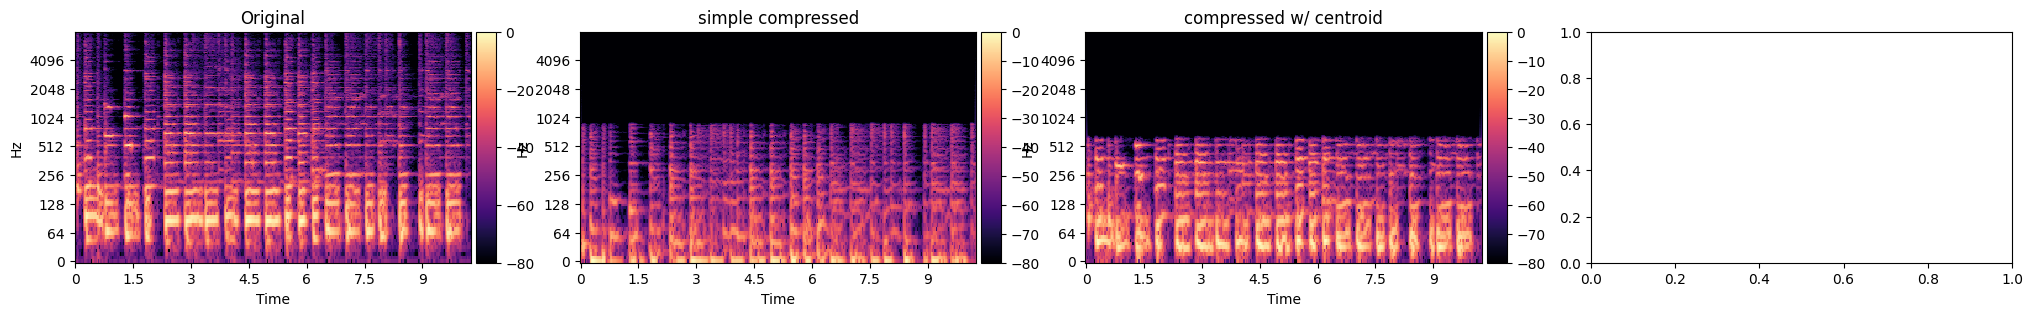

In [776]:
prompt = "happy emoticon" 

foley_language_phrase = foley_interpreter(prompt)
audio = audio_generator(foley_language_phrase, latent_diffusion, np.random.randint(0,10000))
audio_c = audio_post_processor(audio, freq_limit=1000, hop_length=hop_length, stft_channels=stft_channels, sample_rate=sample_rate, loudness=-25)

all_wavs = [audio]
all_titles = ['Original']
for key in audio_c:
    all_wavs.append(audio_c[key])
    print('Loudness of ', key ,loudness_meter.integrated_loudness(audio_c[key]))

    all_titles.append(key)

utils.plot_all(all_wavs, all_titles)

In [777]:
loudness_meter = pyln.Meter(sample_rate)


In [778]:
audio_c.keys()

dict_keys(['simple compressed', 'compressed w/ centroid'])

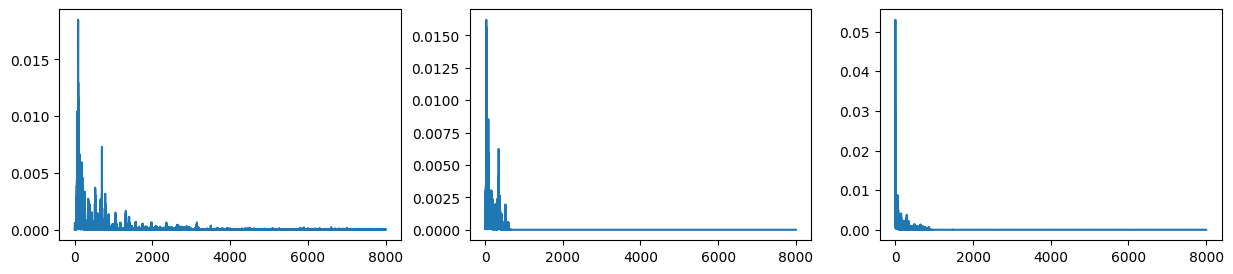

In [779]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
for ind, aud in enumerate([audio, audio_c['compressed w/ centroid'], audio_c['simple compressed']]):
    audio_fft = np.abs(fft.fft(aud))
    xf = fft.fftfreq(len(aud), (1/16000))[:len(aud)//2]
    axs[ind].plot(xf, 2.0/len(aud) * np.abs(audio_fft[0:len(aud)//2]))

In [780]:
80/0.107

747.6635514018692

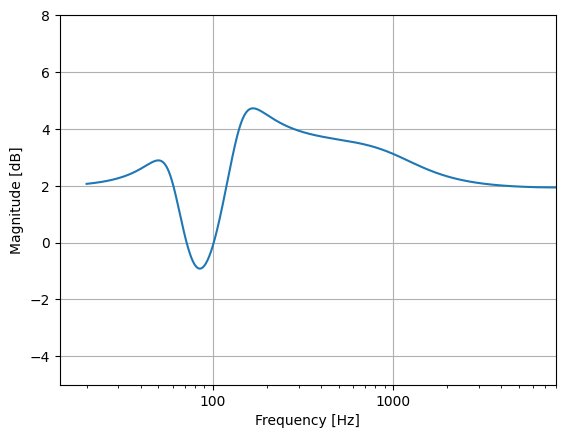

In [830]:
import audio_dspy as adsp

fs = 16000 # set sample rate
eq = adsp.EQ(fs)

#####the first good one#####
# eq.add_LPF(1000, 0.707)
# eq.add_lowshelf(60, 1.4, 2)
# eq.add_notch(90, 0.707)
# eq.add_highshelf(120, 0.707, 3)
#####the first good one completes#####

#####the second good one#####
eq.add_LPF(1000, 0.707)
eq.add_lowshelf(70, 2, 2)
eq.add_highshelf(100, 1.2, 2)
eq.add_highshelf(120, 2, 2)
#####the second good one completes#####
eq.plot_eq_curve(worN=np.logspace(1, 3.3, num=1000, base=20))

plt.grid()
plt.ylim(-5, 8)
plt.xlim(0, 8000)
plt.show()

Loudness after change =  -24.999999999999996
Loudness after change =  -15.464439155697113
Loudness after change =  -25.000000000000007
num rows= 1


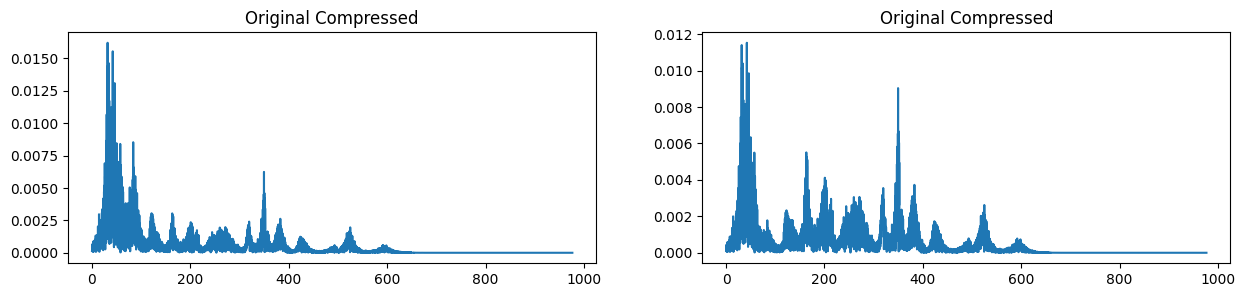

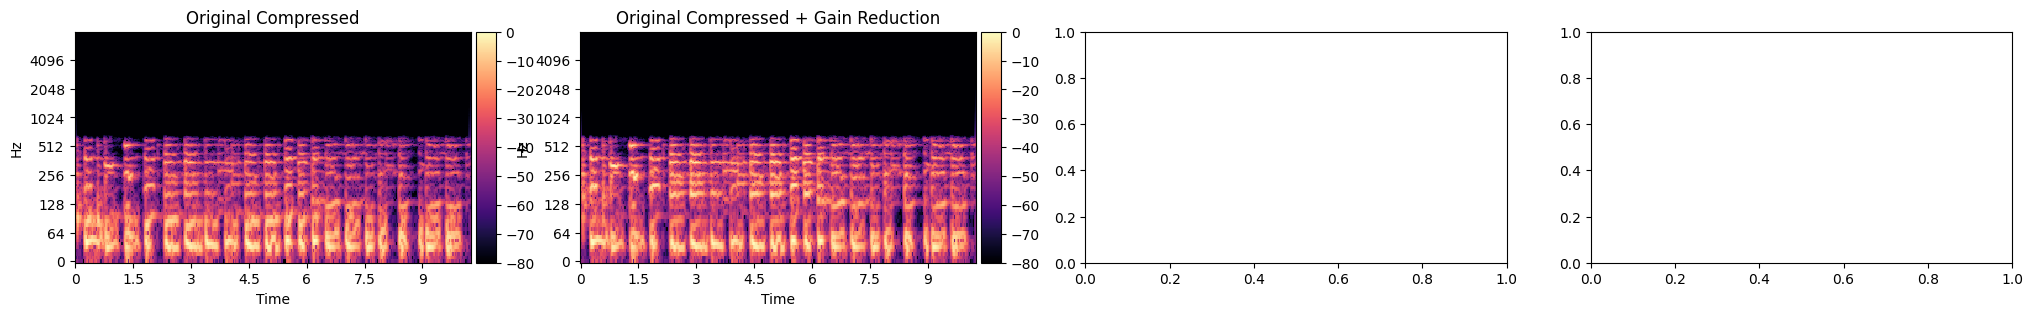

In [831]:
filter = adsp.Filter(2, fs)
filter.set_coefs(b, a)

eq.reset()
print('Loudness after change = ',loudness_meter.integrated_loudness(audio_c['compressed w/ centroid']))
y = eq.process_block(audio_c['compressed w/ centroid'])
print('Loudness after change = ',loudness_meter.integrated_loudness(y))
y /= np.max(np.abs(y))
y = change_loudness(y, -25, loudness_meter)
print('Loudness after change = ',loudness_meter.integrated_loudness(y))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,3))
for ind, aud in enumerate([audio_c['compressed w/ centroid'], y]):
    audio_fft = np.abs(fft.fft(aud))
    xf = fft.fftfreq(len(aud), (1/16000))[:len(aud)//2]
    yf=2.0/len(aud) * np.abs(audio_fft[0:len(aud)//2])
    axs[ind].plot(xf[:10000], yf[:10000])
    # axs[ind].plot(xf, yf)
    if ind == 0:
         axs[ind].set_title("Original Compressed")
    else: 
        axs[ind].set_title("Original Compressed")

utils.plot_all([audio_c['compressed w/ centroid'], y] ,['Original Compressed','Original Compressed + Gain Reduction'])

In [ ]:
#https://audio-dspy.readthedocs.io/en/latest/source/audio_dspy.html#audio_dspy.eq.EQ.process_block

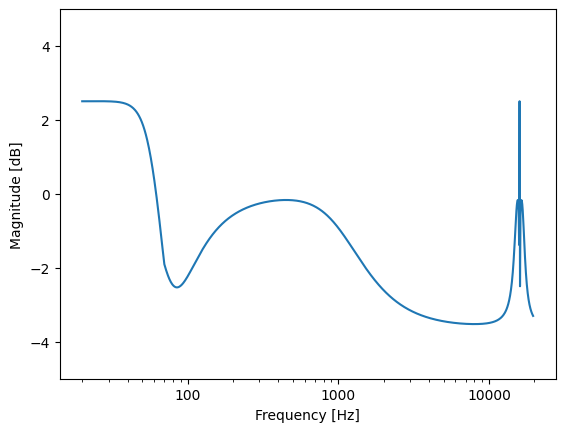

In [761]:
import audio_dspy as adsp

fs = 16000 # set sample rate
eq = adsp.EQ(fs)

eq.add_LPF(1000, 0.707)
eq.add_lowshelf(70, 1.4, 2)
eq.add_notch(70, 0.707)
# eq.add_bell(70, 0.707, 2)
# eq.add_highshelf(120, 0.707, 3)
eq.plot_eq_curve(worN=np.logspace(1, 3.3, num=1000, base=20))

plt.ylim(-5, 5)
plt.show()

num rows= 1


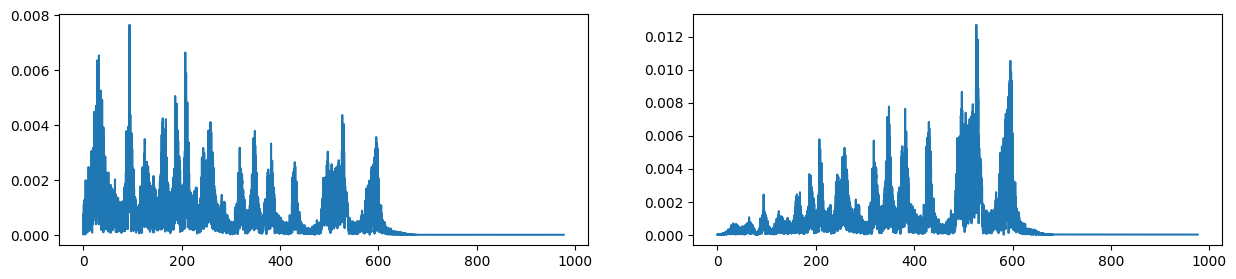

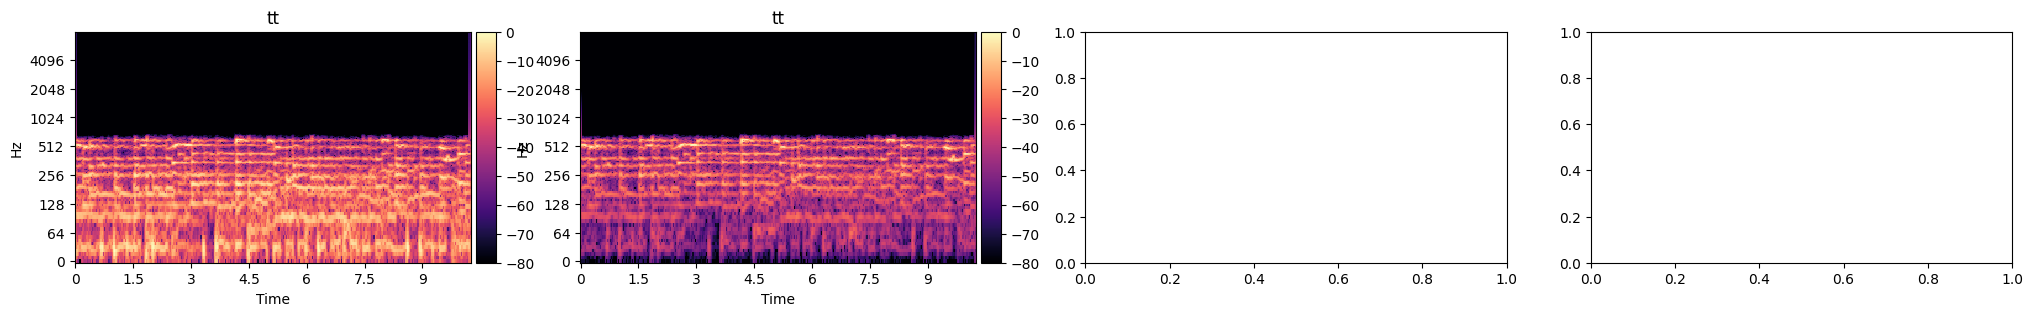

In [710]:
filter = adsp.Filter(2, fs)
filter.set_coefs(b, a)

eq.reset()
y = eq.process_block(audio_c['compressed w/ centroid'])
y /= np.max(np.abs(y))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,3))
for ind, aud in enumerate([audio_c['compressed w/ centroid'], y]):
    audio_fft = np.abs(fft.fft(aud))
    xf = fft.fftfreq(len(aud), (1/16000))[:len(aud)//2]
    yf=2.0/len(aud) * np.abs(audio_fft[0:len(aud)//2])
    axs[ind].plot(xf[:10000], yf[:10000])
    # axs[ind].plot(xf, yf)

utils.plot_all([audio_c['compressed w/ centroid'], y] ,['tt','tt'])

10 70 1 0
Loudness before change =  -36.95728149275033
Loudness after change =  -36.95728149275033
70 400 -10.0 1
Loudness before change =  -26.70424713679268
Loudness after change =  -26.70424713679268
400 1000 1 2
Loudness before change =  -30.486525984247347
Loudness after change =  -30.486525984247347


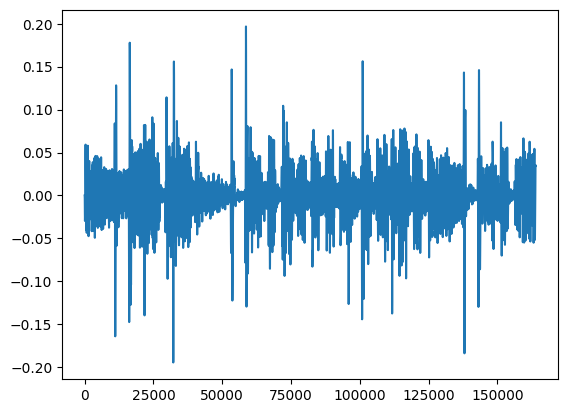

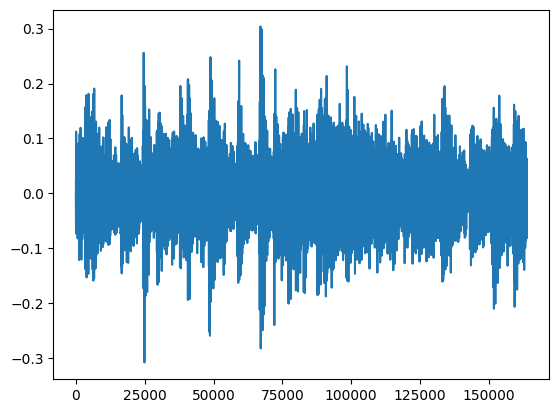

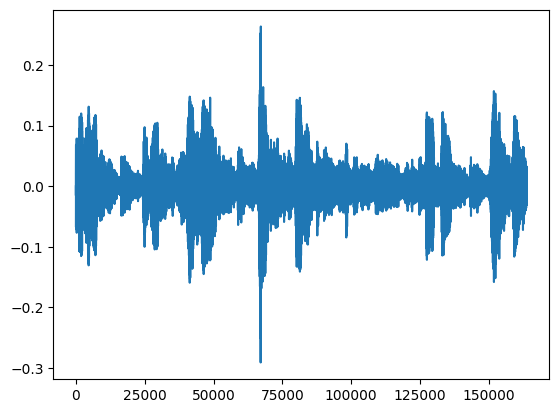

In [471]:
filtered_audio_compressed_w_centroid = np.zeros_like(audio_c['compressed w/ centroid'])
bands = [(10,70), (70,400), (400,1000)]
gain_reduction = [0,0,0]

for ind, (low, high) in enumerate(bands):
    print(low, high, gain[ind], ind)
    b, a = butter_bandpass(low, high, sample_rate, order=3, btype='bandpass')
    f = lfilter(b, a, audio_c['compressed w/ centroid'])

    current_loudness_f = loudness_meter.integrated_loudness(f)
    print('Loudness before change = ',current_loudness_f)
    #f = change_loudness(f, current_loudness_f+gain_reduction[ind], loudness_meter)
    print('Loudness after change = ',loudness_meter.integrated_loudness(f))
    plt.figure()
    plt.plot(f)
    filtered_audio_compressed_w_centroid += 0.000000001*f

filtered_audio_compressed_w_centroid /= np.max(np.abs(filtered_audio_compressed_w_centroid))

num rows= 1


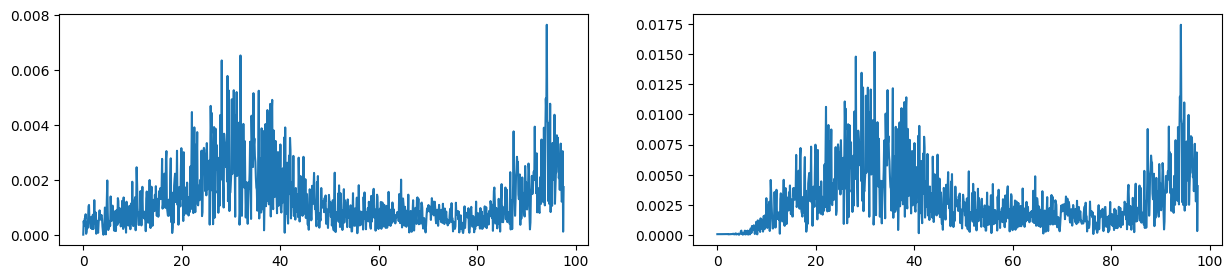

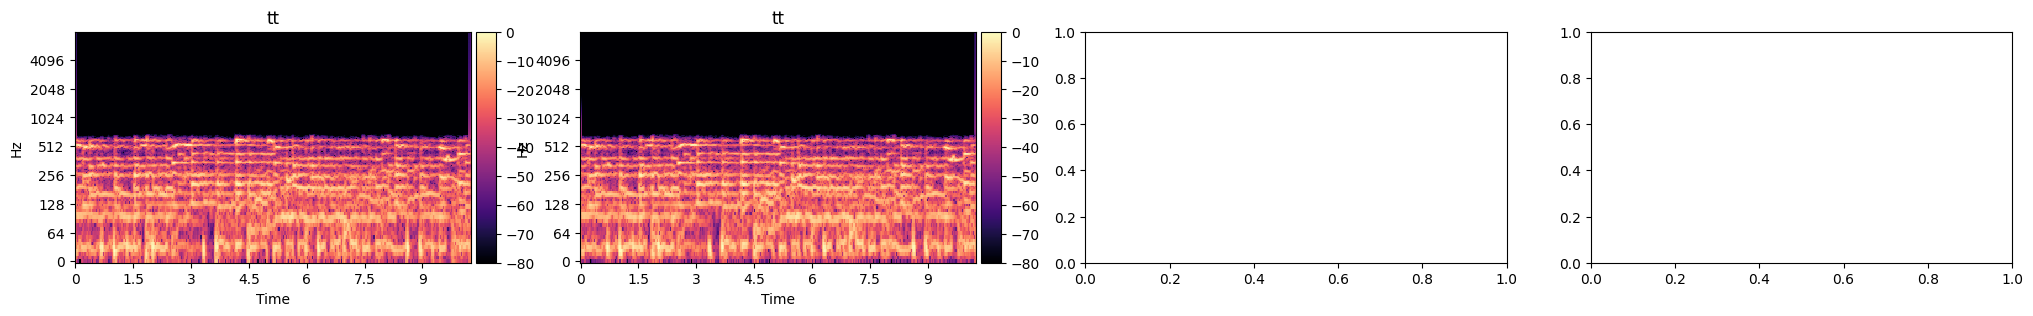

In [472]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,3))
for ind, aud in enumerate([audio_c['compressed w/ centroid'], filtered_audio_compressed_w_centroid]):
    audio_fft = np.abs(fft.fft(aud))
    xf = fft.fftfreq(len(aud), (1/16000))[:len(aud)//2]
    yf=2.0/len(aud) * np.abs(audio_fft[0:len(aud)//2])
    axs[ind].plot(xf[:1000], yf[:1000])
    # axs[ind].plot(xf, yf)

utils.plot_all([audio_c['compressed w/ centroid'], filtered_audio_compressed_w_centroid] ,['tt','tt'])

In [273]:
from scipy.signal import butter, lfilter, freqs

10 70 1 0


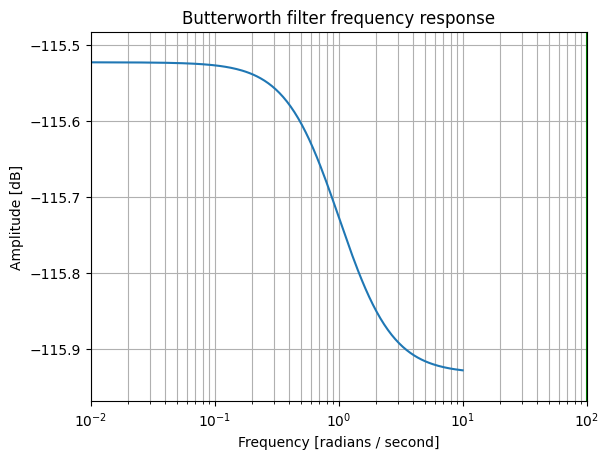

[1.0000016  1.         0.99999521 1.         1.00000479 1.
 0.9999984 ]


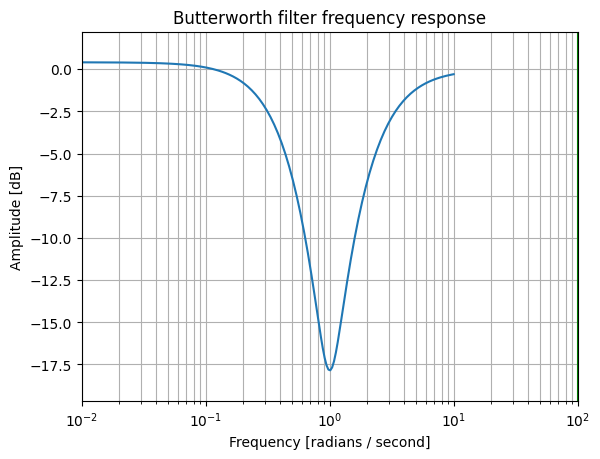

0
70 100 -10.0 1


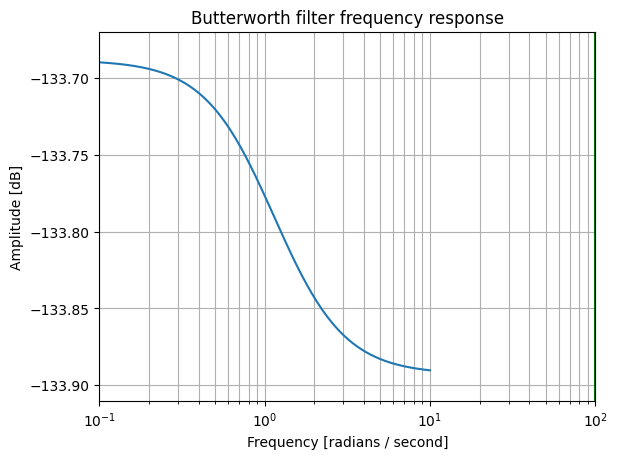

[ -9.9999998  -10.         -10.00000061 -10.          -9.99999939
 -10.         -10.0000002 ]


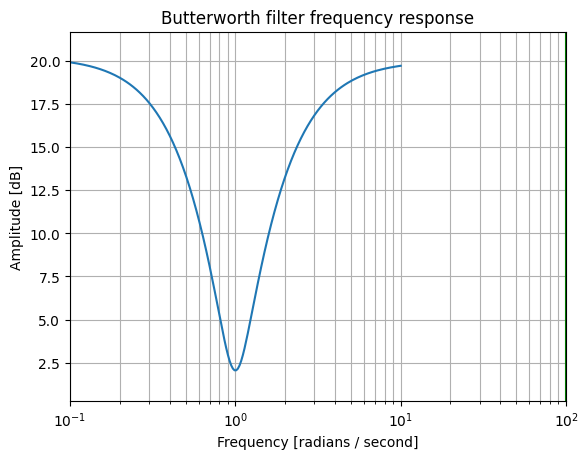

1
100 1000 1 2


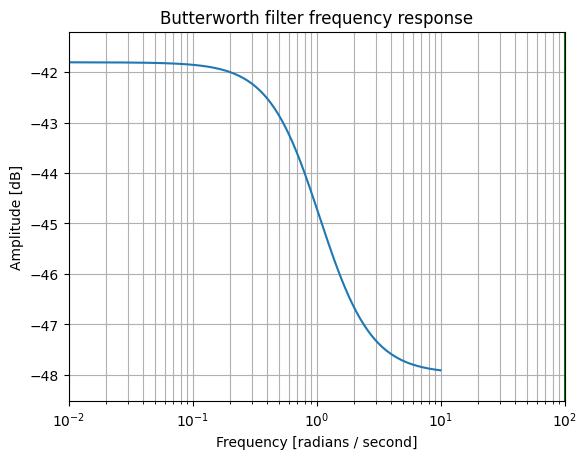

[1.00399179 1.         0.98802462 1.         1.01197538 1.
 0.99600821]


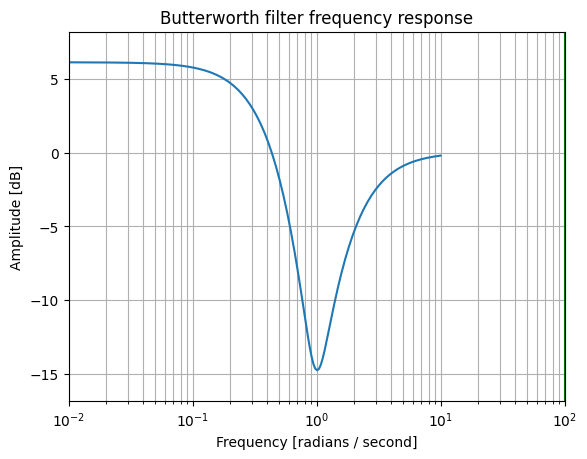

2


In [474]:
filtered_audio_compressed_w_centroid = np.zeros_like(audio_c['compressed w/ centroid'])
bands = [(10,70), (70,100), (100,1000)]
gain = [1,-10.,1]

for ind, (low, high) in enumerate(bands):
    print(low, high, gain[ind], ind)
    b, a = butter_bandpass(low, high, sample_rate, order=3, btype='bandpass')
    w, h = freqs(b, a)
    plt.figure()
    plt.semilogx(w, 20 * np.log10(abs(h)))
    plt.title('Butterworth filter frequency response')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(100, color='green') # cutoff frequency
    plt.show()
    b = b + gain[ind]
    print(b)
    w, h = freqs(b, a)
    plt.figure()
    plt.semilogx(w, 20 * np.log10(abs(h)))
    plt.title('Butterworth filter frequency response')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(100, color='green') # cutoff frequency
    plt.show()
    print(ind)
    filtered_audio_compressed_w_centroid += gain[ind]*lfilter(b, a, audio_c['compressed w/ centroid'])
   
    # filtered_audio_compressed_w_centroid += butter_bandpass_filter_withgain(audio_c['compressed w/ centroid'], highcut=high, lowcut=low, \
    #                    fs=sample_rate,  order=3, btype='bandpass', gain=gain[ind])

# Normalize the filtered signal
# filtered_audio_compressed_w_centroid /= np.max(np.abs(filtered_audio_compressed_w_centroid))

num rows= 1


ValueError: Audio data must be between -1 and 1 when normalize=False.

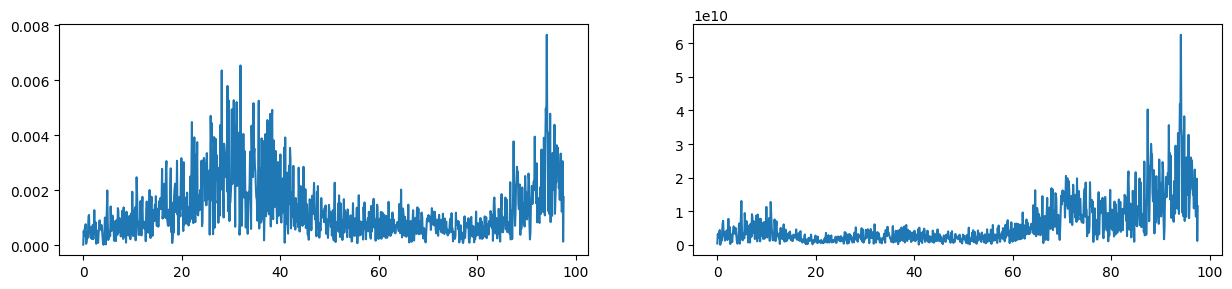

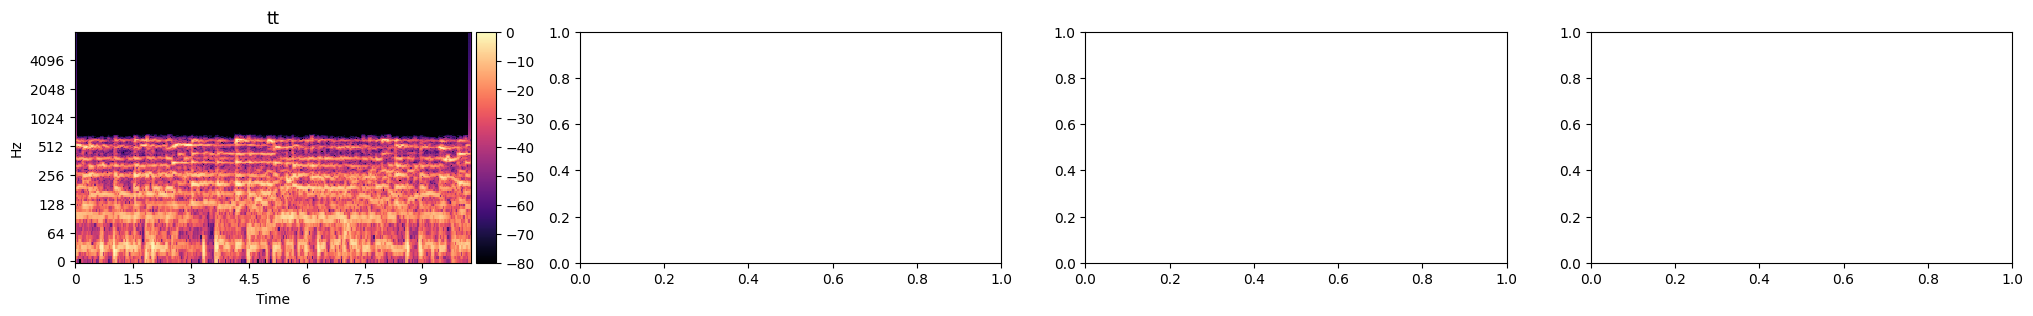

In [475]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,3))
for ind, aud in enumerate([audio_c['compressed w/ centroid'], filtered_audio_compressed_w_centroid]):
    audio_fft = np.abs(fft.fft(aud))
    xf = fft.fftfreq(len(aud), (1/16000))[:len(aud)//2]
    yf=2.0/len(aud) * np.abs(audio_fft[0:len(aud)//2])
    axs[ind].plot(xf[:1000], yf[:1000])
    # axs[ind].plot(xf, yf)


utils.plot_all([audio_c['compressed w/ centroid'], filtered_audio_compressed_w_centroid]\
               ,['tt','tt'])

Loudness before change filtered_audio_compressed_w_centroid1=  -30.57102494884311
Loudness before audio =  -30.54994914386954
Loudness before filtered_audio_compressed_w_centroid1=  -30.57102494884311
num rows= 1


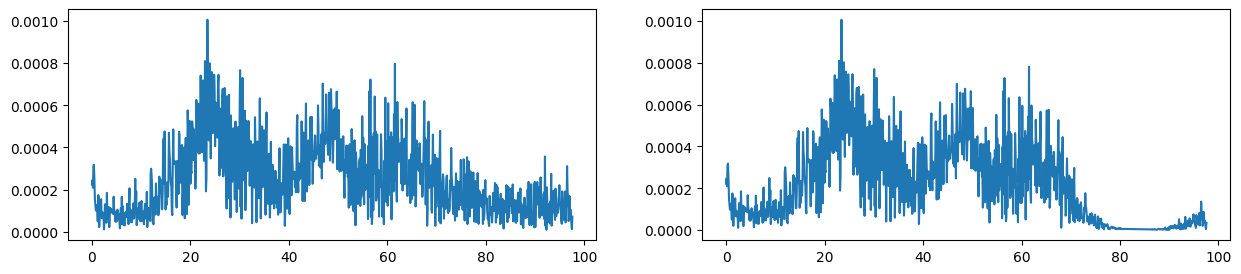

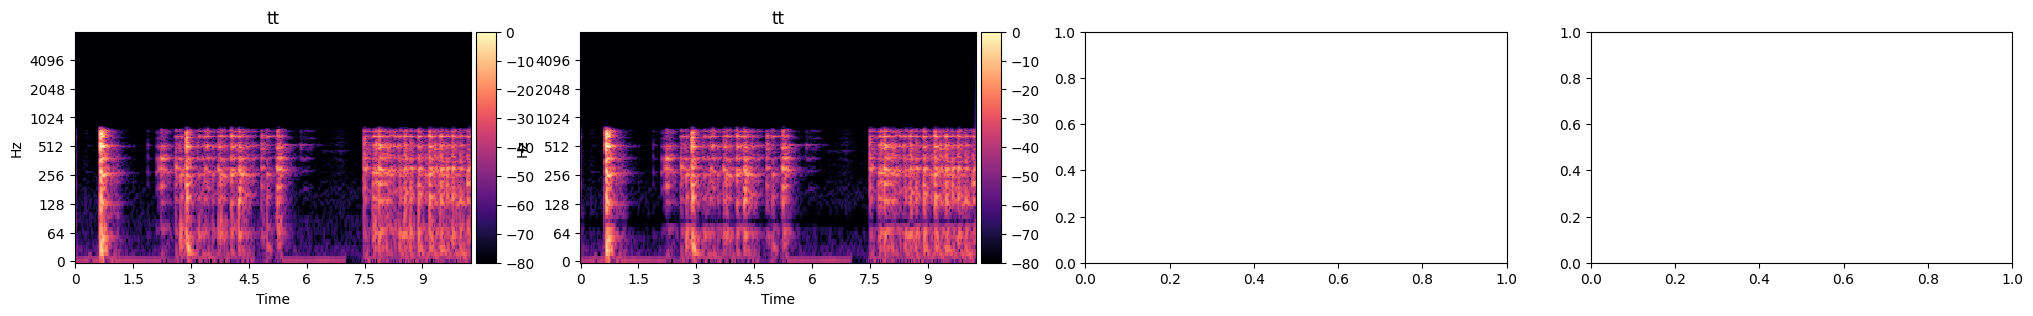

In [424]:
actuator_center_frequency_band = (70,100)#hz

filtered_audio_compressed_w_centroid = butter_bandpass_filter(audio_c['compressed w/ centroid'], highcut=actuator_center_frequency_band[1], lowcut=actuator_center_frequency_band[0], \
                       fs=sample_rate,  order=3, btype='bandstop')


print('Loudness before change filtered_audio_compressed_w_centroid1= ',loudness_meter.integrated_loudness(filtered_audio_compressed_w_centroid))

# filtered_audio_compressed_w_centroid = change_loudness(filtered_audio_compressed_w_centroid, -25, loudness_meter)


print('Loudness before audio = ',loudness_meter.integrated_loudness(audio))
print('Loudness before filtered_audio_compressed_w_centroid1= ',loudness_meter.integrated_loudness(filtered_audio_compressed_w_centroid))


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,3))
for ind, aud in enumerate([audio_c['compressed w/ centroid'], filtered_audio_compressed_w_centroid]):
    audio_fft = np.abs(fft.fft(aud))
    xf = fft.fftfreq(len(aud), (1/16000))[:len(aud)//2]
    yf=2.0/len(aud) * np.abs(audio_fft[0:len(aud)//2])
    axs[ind].plot(xf[:1000], yf[:1000])

utils.plot_all([audio_c['compressed w/ centroid'], filtered_audio_compressed_w_centroid]\
               ,['tt','tt'])

Loudness before audio =  -23.021290369402237
Loudness before filtered_audio_compressed_w_centroid1=  -26.944538945017513


num rows= 1


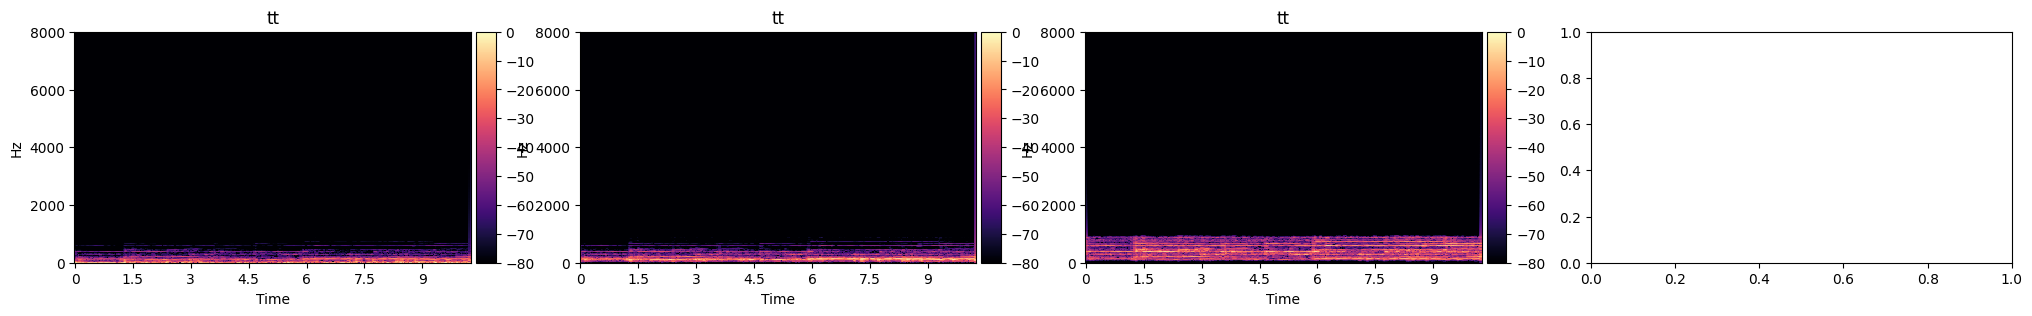

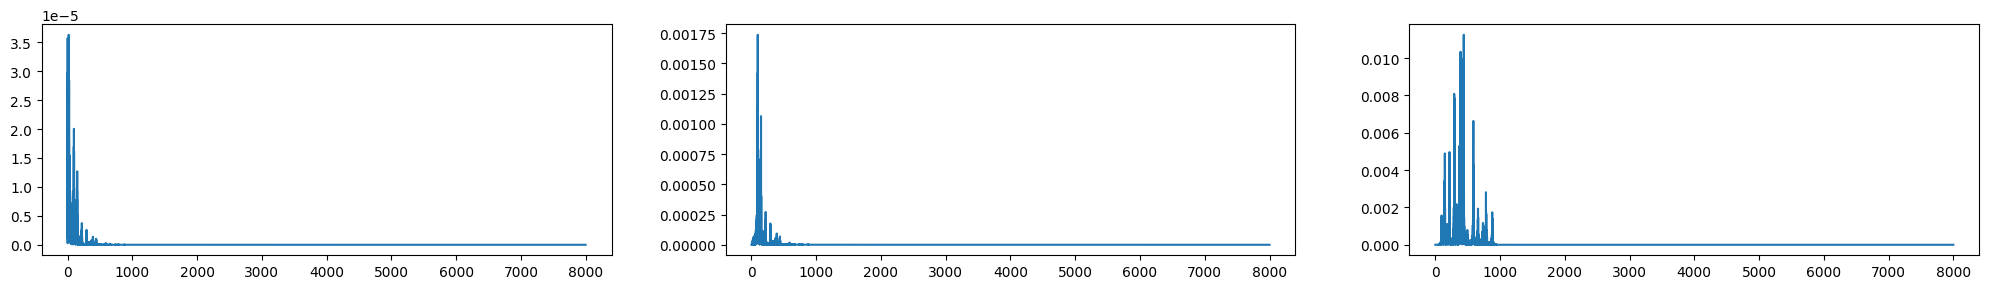

In [103]:
actuator_center_frequency_band = (20,100)#hz

filtered_audio_compressed_w_centroid1 = butter_bandpass_filter(audio_c['compressed w/ centroid'], highcut=actuator_center_frequency_band[0], lowcut=1, \
                       fs=sample_rate,  order=3, btype='lowpass')

filtered_audio_compressed_w_centroid2 = butter_bandpass_filter(audio_c['compressed w/ centroid'], highcut=actuator_center_frequency_band[1], lowcut=actuator_center_frequency_band[0], \
                       fs=sample_rate,  order=3, btype='bandpass')

filtered_audio_compressed_w_centroid3 = butter_bandpass_filter(audio_c['compressed w/ centroid'], highcut=actuator_center_frequency_band[1], lowcut=8000, \
                       fs=sample_rate,  order=3, btype='highpass')

filtered_audio_compressed_w_centroid = filtered_audio_compressed_w_centroid+filtered_audio_compressed_w_centroid2+filtered_audio_compressed_w_centroid3

utils.plot_all([filtered_audio_compressed_w_centroid1, filtered_audio_compressed_w_centroid2, filtered_audio_compressed_w_centroid3]\
               ,['tt','tt','tt'])


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,3))
for ind, aud in enumerate([filtered_audio_compressed_w_centroid1, filtered_audio_compressed_w_centroid2, filtered_audio_compressed_w_centroid3]):
    audio_fft = np.abs(fft.fft(aud))
    xf = fft.fftfreq(len(aud), (1/16000))[:len(aud)//2]
    axs[ind].plot(xf, 2.0/len(aud) * np.abs(audio_fft[0:len(aud)//2]))

In [84]:

print('Loudness before audio = ',loudness_meter.integrated_loudness(audio))
print('Loudness before filtered_audio_compressed_w_centroid1= ',loudness_meter.integrated_loudness(filtered_audio_compressed_w_centroid1))
print('Loudness before filtered_audio_compressed_w_centroid2= ',loudness_meter.integrated_loudness(filtered_audio_compressed_w_centroid2))
print('Loudness before filtered_audio_compressed_w_centroid3= ',loudness_meter.integrated_loudness(filtered_audio_compressed_w_centroid3))


Loudness before audio =  -18.08724051396388
Loudness before filtered_audio_compressed_w_centroid1=  -60.30469646069206
Loudness before filtered_audio_compressed_w_centroid2=  -46.81505086429837
Loudness before filtered_audio_compressed_w_centroid3=  -25.04801090083714


Hack for gain increase for IPython. Peak norm if peaks>1.0 implemented. Loudness is =  -26.944538945017513
Loudness before filtered_audio_compressed_w_centroid1=  -26.944538945017513
Loudness before filtered_audio_compressed_w_centroid2=  -60.00000000000001
Loudness before filtered_audio_compressed_w_centroid3=  -19.999999999999996
Loudness before filtered_audio_compressed_w_centroid=  -18.608181024291646


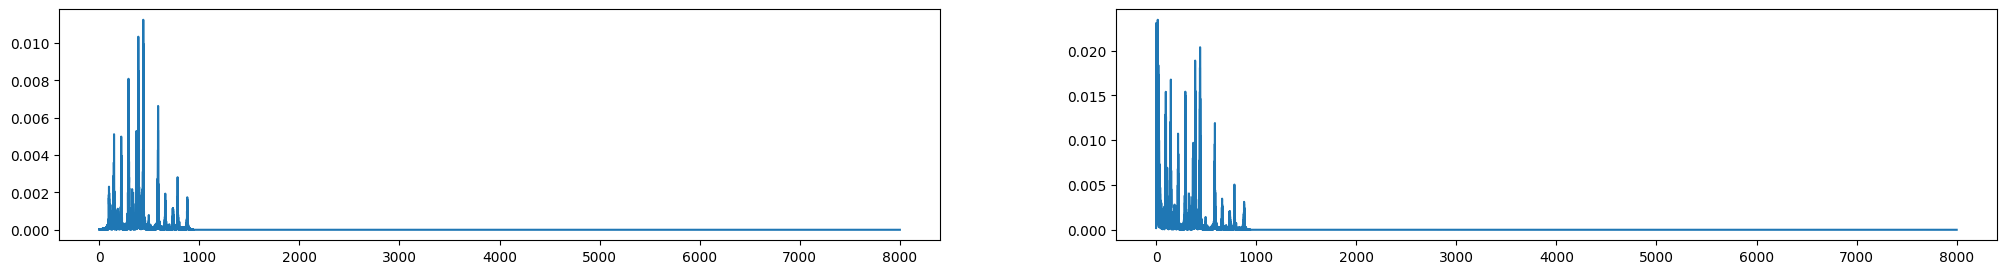

In [111]:
filtered_audio_compressed_w_centroid1 = change_loudness(filtered_audio_compressed_w_centroid1, -20, loudness_meter)
filtered_audio_compressed_w_centroid2 = change_loudness(filtered_audio_compressed_w_centroid2, -60, loudness_meter)
filtered_audio_compressed_w_centroid3 = change_loudness(filtered_audio_compressed_w_centroid3, -20, loudness_meter)

filtered_audio_compressed_w_centroid = filtered_audio_compressed_w_centroid1 + filtered_audio_compressed_w_centroid2 + filtered_audio_compressed_w_centroid3

print('Loudness before filtered_audio_compressed_w_centroid1= ',loudness_meter.integrated_loudness(filtered_audio_compressed_w_centroid1))
print('Loudness before filtered_audio_compressed_w_centroid2= ',loudness_meter.integrated_loudness(filtered_audio_compressed_w_centroid2))
print('Loudness before filtered_audio_compressed_w_centroid3= ',loudness_meter.integrated_loudness(filtered_audio_compressed_w_centroid3))
print('Loudness before filtered_audio_compressed_w_centroid= ',loudness_meter.integrated_loudness(filtered_audio_compressed_w_centroid))


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25,3))
for ind, aud in enumerate([audio_c['compressed w/ centroid'], filtered_audio_compressed_w_centroid]):
    audio_fft = np.abs(fft.fft(aud))
    xf = fft.fftfreq(len(aud), (1/16000))[:len(aud)//2]
    axs[ind].plot(xf, 2.0/len(aud) * np.abs(audio_fft[0:len(aud)//2]))